# Inverser dynamics regression SNR sensitivity

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
%load_ext kedro.extras.extensions.ipython

                    INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=209678;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=779429;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/06/24 10:51:35] INFO     Kedro project phd                                                      ]8;id=579990;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=476742;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=561807;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=288598;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=782820;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=941809;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

In [14]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime, prime_eq_to_SI_eq
import statsmodels.api as sm
#import zigzag
import logging
log = logging.getLogger(__name__)

#import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (12,10)

import seaborn as sns
from phd.visualization.maps import plot_map, plot_trips, plot_missions
from phd.helpers import derivative
from vessel_manoeuvring_models.data.lowpass_filter import lowpass_filter
from vessel_manoeuvring_models.KF_multiple_sensors import KalmanFilter
from vessel_manoeuvring_models.prime_system import get_denominator
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters['symbol']
from vessel_manoeuvring_models.substitute_dynamic_symbols import lambdify, run, expression_to_python_method
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
from sympy.matrices.immutable import ImmutableDenseMatrix
from sympy import Eq
#from vessel_manoeuvring_models.EKF_multiple_sensors import ExtendedKalmanFilter, update_gradient
from vessel_manoeuvring_models.EKF_VMM_1d import ExtendedKalmanFilterVMMWithAccelerometer
from vessel_manoeuvring_models.models.IMO_simulations import zigzag
from phd.pipelines.load_7m.nodes import derived_channels
from vessel_manoeuvring_models.extended_kalman_filter import extended_kalman_filter, time_steps_to_df
from phd.paper.equation import to_latex
import phd.pipelines.load_wPCC.reference_frames as reference_frames
from phd.pipelines.filter.nodes import lowpass
import sympy.physics.mechanics as me
from phd.paper.equation import eq_dottify
#from load_data import load, filter, calculate_accelerometer_corrections, accelerometers_to_origo, calculated_accelerometer, plot_accelerations, plot_accelerometers
from phd.pipelines.regression_ID.nodes import (regress_hull_inverse_dynamics, _regress_hull_inverse_dynamics, regress_inverse_dynamics, 
                                            _regress_inverse_dynamics, exclude_parameters_global, gather_data)
import seaborn as sns
from phd.visualization.plot_prediction import predict
from scipy.interpolate import interp1d
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
import matplotlib.pyplot as plt
import paper

In [3]:
#%reload_kedro

In [4]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

id = 22773
datas = {}
N = 3
for i in range(1,N+1):
    datas[i] = catalog.load(f"{ship}.tests_ek_smooth{i}")[str(id)]()

smoother_results = {}
for i in range(1,N+1):
    smoother_results[i] = catalog.load(f"wPCC.smoother_result{i}")[f'{id}']()

ekfs={}
for i in range(1,N+1):
    ekfs[i] = catalog.load(f"wPCC.ekf{i}")


[06/06/24 10:51:48] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=558752;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=885719;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=464833;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=496112;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth2' (PartitionedDataset)...  ]8;id=201900;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=237398;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth3' (PartitionedDataset)...  ]8;id=915668;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=512705;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.smoother_result1' (PartitionedDataset)...  ]8;id=241128;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=855329;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.smoother_result2' (PartitionedDataset)...  ]8;id=747095;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=13389;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.smoother_result3' (PartitionedDataset)...  ]8;id=67011;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=495538;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.ekf1' (ExtendedKalmanFilterDataSet)...     ]8;id=79533;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=466258;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[06/06/24 10:52:01] INFO     Loading data from 'wPCC.ekf2' (ExtendedKalmanFilterDataSet)...     ]8;id=894620;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=538440;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.ekf3' (ExtendedKalmanFilterDataSet)...     ]8;id=76179;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=688582;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
SNRs = {}
for i,ekf in ekfs.items():
    SNRs[i] = np.round(np.mean(np.diagonal(ekf.SNR)),3)

In [6]:
dataframes = {f"SNR:{SNRs[i]}" : data for i, data in datas.items()}

In [7]:
models_PU = {i:catalog.load(f"{ship}.models_ID_hull_rudder{i}")['Abkowitz']() for i in range(1,N+1)}
models_PI = {i:catalog.load(f"{ship}.models_ID_hull{i}")['semiempirical_covered']() for i in range(1,N+1)}

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder1'                    ]8;id=896402;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=74477;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder2'                    ]8;id=517698;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659926;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder3'                    ]8;id=143262;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=764130;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_ID_hull1' (PartitionedDataset)...   ]8;id=620301;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=404679;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[06/06/24 10:52:06] INFO     Loading data from 'wPCC.models_ID_hull2' (PartitionedDataset)...   ]8;id=697237;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=639964;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[06/06/24 10:52:10] INFO     Loading data from 'wPCC.models_ID_hull3' (PartitionedDataset)...   ]8;id=910437;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=638263;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

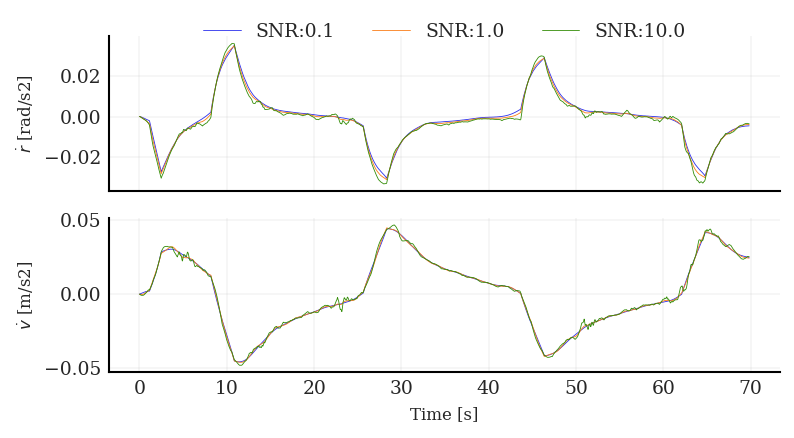

In [25]:
units={
    "r1d":"rad/s2",
    "v1d":"m/s2",
}
symbols={
    "r1d":r"\dot{r}",
    "v1d":r"\dot{v}",
}
fig = plot(dataframes, keys=['v1d','r1d'], ncols=1, units=units, symbols=symbols);
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.tight_layout()
paper.save_fig(fig, "accelerations.svg")

In [17]:
_ = []
for i,model in models_PI.items():
    
    s = pd.Series(model.parameters, name=f"PI SNR {SNRs[i]}")
    s["SNR"] = SNRs[i]
    s["type"] = "PI"
    _.append(s)

for i,model in models_PU.items():
    
    s = pd.Series(model.parameters, name=f"PU SNR {SNRs[i]}")
    s["SNR"] = SNRs[i]
    #s["type"] = "PU"
    _.append(s)

df_parameters = pd.concat(_,axis=1).transpose()

df_parameters = df_parameters.dropna(axis=1)

mask = (df_parameters.diff().fillna(0)==0).all(axis=0)
columns = df_parameters.columns[~mask]
df_parameters = df_parameters[columns].copy()

mask = (df_parameters.iloc[0:2].diff().fillna(0)==0).all(axis=0)
columns = df_parameters.columns[~mask]
df_parameters = df_parameters[columns].copy()

df_parameters['model'] = [index[0:2] for index in df_parameters.index]

In [11]:
df_parameters_pivot = df_parameters.pivot(columns='SNR', index='model')
df_parameters_pivot

Xvv                            Yv                            Nv                           Xrr                            Nr                           Xvr
SNR        0.1       1.0       10.0      0.1       1.0       10.0      0.1       1.0       10.0      0.1       1.0       10.0      0.1       1.0       10.0      0.1       1.0       10.0
model                                                                                                              
PI     0.000239  0.000101  0.000169 -0.008826 -0.008846 -0.009038 -0.002824 -0.002832 -0.002813  -0.00005  -0.00003 -0.000152 -0.001573 -0.001578 -0.001576  0.003141  0.003128  0.003049
PU    -0.014517 -0.014812  -0.01471 -0.020345  -0.02032 -0.020667  0.000397   0.00018 -0.000122 -0.002005 -0.002183 -0.002303 -0.001964 -0.002208 -0.002567 -0.009648 -0.010018 -0.010084

In [49]:
table = df_parameters_pivot.transpose()
table.reset_index(inplace=True)
#table.index.name='Par.'
table.rename(columns={'level_0':'Coefficient'}, inplace=True)
table['Coefficient'] = table['Coefficient'].apply(lambda x:fr"${{{x[0]}'}}_{{{x[1:]}}}$")
mask = table['Coefficient'].duplicated()
table.loc[mask,'Coefficient'] = ''
table.to_csv(paper.file_path_with_nb_ref("pivot.csv", directory='tables'), index=False)

In [50]:
table

model,Coefficient,SNR,PI,PU
0,${X'}_{vv}$,0.1,0.000239,-0.014517
1,,1.0,0.000101,-0.014812
2,,10.0,0.000169,-0.01471
3,${Y'}_{v}$,0.1,-0.008826,-0.020345
4,,1.0,-0.008846,-0.02032
5,,10.0,-0.009038,-0.020667
6,${N'}_{v}$,0.1,-0.002824,0.000397
7,,1.0,-0.002832,0.00018
8,,10.0,-0.002813,-0.000122
9,${X'}_{rr}$,0.1,-0.00005,-0.002005


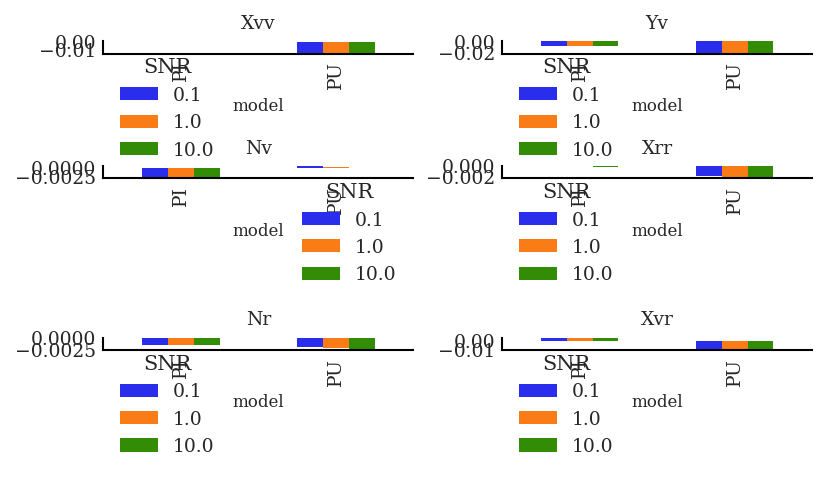

In [18]:
fig,axes=plt.subplots(nrows=3, ncols=2)
for ax,key in zip(axes.flatten(),df_parameters.columns):
    
    if key=='SNR':
        continue

    if key=='model':
        continue
    
    df_parameters_pivot.plot.bar(y=key,ax=ax)
    ax.set_title(key)

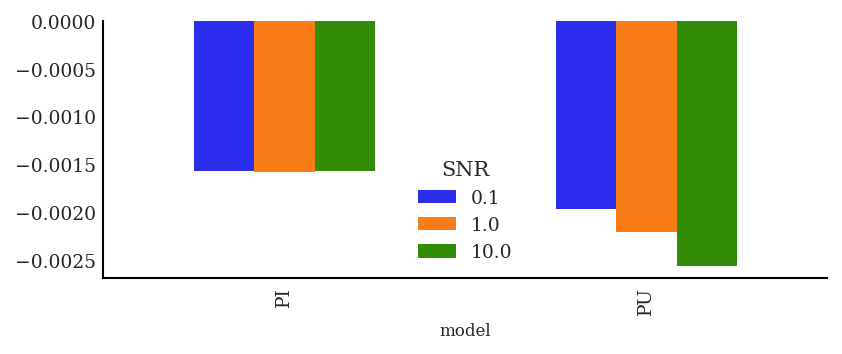

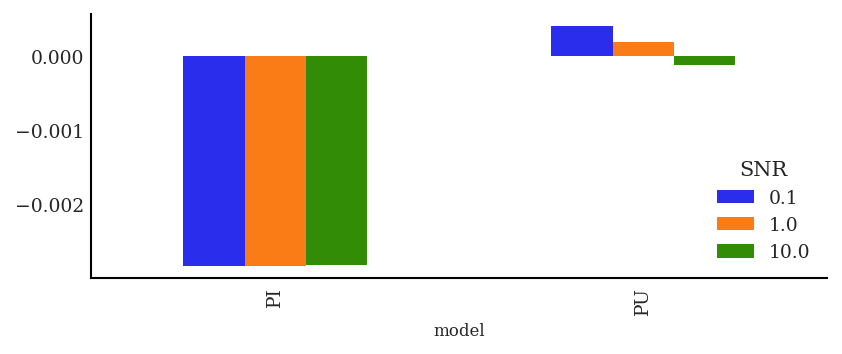

In [60]:
fig,ax=plt.subplots()
fig.set_size_inches(2*2.75,2.25)
key='Nr'
df_parameters_pivot.plot.bar(y=key,ax=ax)
paper.save_fig(fig,f"{key}.svg")

fig,ax=plt.subplots()
fig.set_size_inches(2*2.75,2.25)
key='Nv'
df_parameters_pivot.plot.bar(y=key,ax=ax)
paper.save_fig(fig,f"{key}.svg")

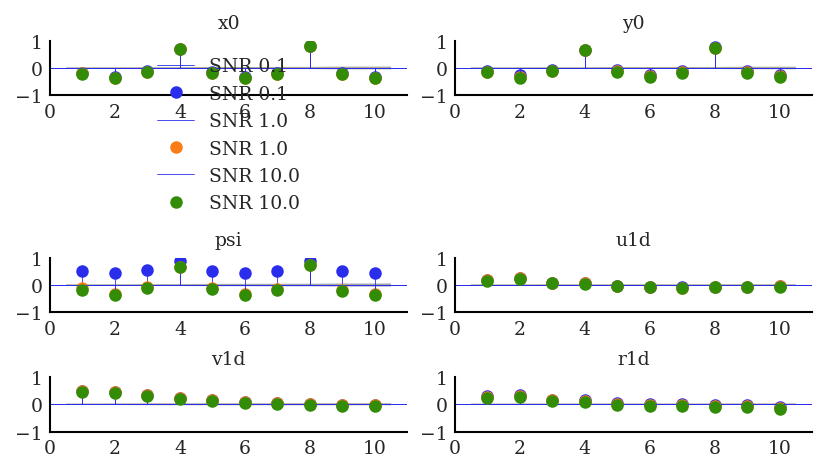

In [20]:
for i,result in smoother_results.items():
    type='autocorr'
    label=f"SNR {SNRs[i]}"
    if i==1:
        fig = result.plot_innovation(type=type, label=label);
    else:
        result.plot_innovation(type=type, fig=fig, label=label);

fig.axes[0].legend()

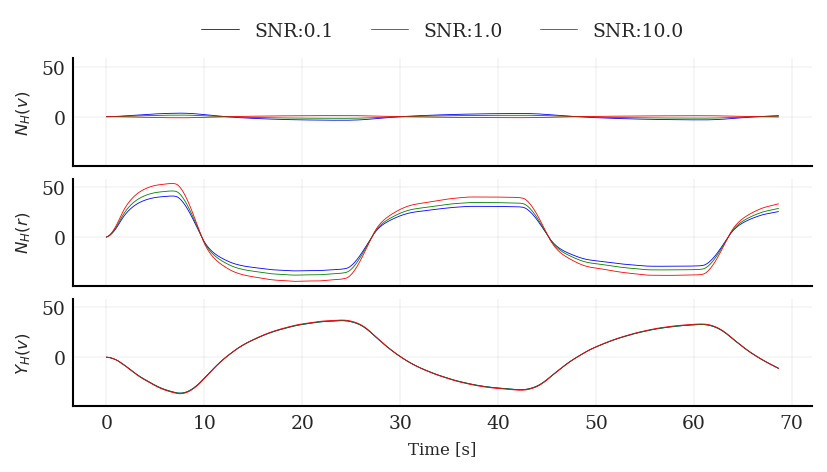

In [21]:
data = preprocess(datas[2].copy(), ship_data=ship_data)

names = [f"SNR:{SNRs[i]}" for i,model in models_PU.items()]
models = {names[i-1]:model for i,model in models_PU.items()}

styles={
    names[0]:{'style':'b-', 'label':names[0]},
    names[1]:{'style':'g-', 'label':names[1]},
    names[2]:{'style':'r-', 'label':names[2]},  
}


df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)

df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr','Yr+Yrrr'], inplace=True)
renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
df_joined_parameter_contributions.rename(columns=renames, inplace=True)


fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
    df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
    df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)
    
    df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr','Yr+Yrrr'], inplace=True)
        
    renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
    df_joined_parameter_contributions.rename(columns=renames, inplace=True)
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)
for ax in axes[0:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)